In [4]:
import numpy as np
import pandas as pd
import scipy 
import matplotlib.pyplot as plt
from scipy.optimize import fmin
import ray 
import os, sys
from Sepp_BarrierOption_DEJD import *

try:
    ray.init(log_to_driver=False)
except RuntimeError:
    ray.shutdown()
    ray.init(log_to_driver=False)

In [5]:
IV_2021 = pd.read_csv('2021-04-01.csv')
IV_2021.date = pd.to_datetime(IV_2021.date)
IV_2021.loc[:,'hour'] = IV_2021.date.apply(lambda x: x.hour)
IV_2021.sort_values('date', inplace=True)

In [6]:
IV_2021.loc[:, 'moneynessOLD'] = IV_2021.moneyness
IV_2021.loc[:, 'moneyness'] = IV_2021.strike / IV_2021.index_price

In [7]:
_id = IV_2021.moneyness <= 1.2
_id&= IV_2021.moneyness >= .8

pd.pivot_table(IV_2021.loc[_id,:], index = 'hour',
               aggfunc='count', 
               values = 'instrument_price',
               columns = 'moneynessOLD', margins=True)

moneynessOLD,0.81,0.82,0.84,0.85,0.86,0.88,0.89,0.9,0.91,0.92,...,1.11,1.12,1.13,1.15,1.16,1.17,1.18,1.19,1.2,All
hour,,,,,,,,,,,,,,,,,,,,,
6,11.0,NaN,NaN,4.0,NaN,2.0,NaN,2.0,1.0,NaN,...,NaN,2.0,NaN,3.0,NaN,NaN,2.0,NaN,NaN,71
7,15.0,29.0,NaN,63.0,NaN,50.0,NaN,6.0,NaN,31.0,...,5.0,28.0,NaN,20.0,9.0,NaN,NaN,34.0,NaN,629
8,44.0,23.0,NaN,86.0,NaN,58.0,1.0,9.0,1.0,37.0,...,3.0,43.0,NaN,33.0,7.0,NaN,NaN,40.0,NaN,857
9,5.0,NaN,NaN,3.0,NaN,1.0,NaN,NaN,NaN,2.0,...,NaN,2.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,38
10,3.0,NaN,NaN,8.0,NaN,5.0,NaN,NaN,1.0,2.0,...,NaN,4.0,NaN,3.0,NaN,NaN,NaN,8.0,NaN,70
11,29.0,21.0,1.0,75.0,NaN,60.0,NaN,5.0,4.0,20.0,...,7.0,18.0,NaN,21.0,15.0,NaN,4.0,35.0,NaN,720
12,NaN,53.0,NaN,61.0,NaN,1.0,31.0,11.0,2.0,22.0,...,23.0,12.0,12.0,NaN,28.0,NaN,NaN,28.0,2.0,550
13,NaN,97.0,NaN,56.0,80.0,NaN,99.0,2.0,13.0,41.0,...,50.0,10.0,48.0,NaN,46.0,24.0,NaN,11.0,39.0,1238
14,NaN,46.0,NaN,46.0,2.0,NaN,34.0,7.0,1.0,21.0,...,20.0,5.0,17.0,NaN,17.0,NaN,NaN,19.0,3.0,494


In [8]:
last_iv_2021 = []

for instrument  in list(set(IV_2021.instrument_name)):
    _id = IV_2021.instrument_name == instrument
    _id&= IV_2021.hour == 13
    row = IV_2021.loc[_id, :].iloc[-2:-1,:]
    last_iv_2021.append(row)
    
last_iv_2021 = pd.concat(last_iv_2021)
last_iv_2021.loc[last_iv_2021.is_call == 0, 'is_call'] = -1

# remove close to maturity options
last_iv_2021 = last_iv_2021.loc[last_iv_2021.days_to_maturity >= 7,:]
last_iv_2021 = last_iv_2021.loc[last_iv_2021.days_to_maturity <= 180,:]


# remove Out-of-Money options
# _id  = last_iv_2021.moneyness > .9
# _id &= last_iv_2021.moneyness < 1.1

_id_Call = (last_iv_2021.moneyness >= 1) & (last_iv_2021.moneyness <= 1.1) & (last_iv_2021.is_call == 1) 
_id_Put = (last_iv_2021.moneyness <= 1)  & (last_iv_2021.moneyness >= .9)  & (last_iv_2021.is_call == -1) 
_id = _id_Call + _id_Put

last_iv_2021 = last_iv_2021.loc[_id,:]
last_iv_2021 = last_iv_2021.sort_values('maturity')

print(len(last_iv_2021), np.sum(last_iv_2021.is_call==1), np.sum(last_iv_2021.is_call==-1))

23 12 11


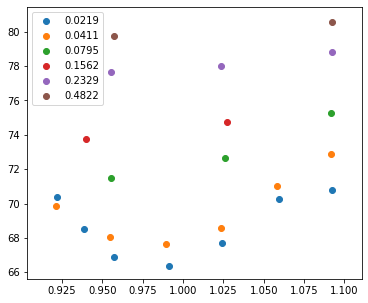

In [9]:
plt.figure(figsize=(6,5))
tau_arr = sorted(list(set(last_iv_2021.tau)))

for tau in tau_arr:
    _id = last_iv_2021.tau == tau
    plt.scatter(last_iv_2021.moneyness.loc[_id],
                last_iv_2021.mark_iv.loc[_id], label=tau)
    
plt.legend()

In [10]:
def getBS_iv(S, sigma0, r, d, T, t, K, S_u, S_d, si, phi_bar_u, phi_bar_d, target_price, N=16):
    _lambda = 0.00000001 # no jump at all
    eta1 = .3 # mean of positive jump
    eta2 = .3 # mean of negative jump
    phi_bar_u = 0
    phi_bar_d = 0
    q1 = 0.5 # probability of positive jump
    q2 = 1 - q1

    def BS_sigma_loss_fn(sigma):
        if sigma <= 0:
            return 5000
        return (BarrierOptionPricer(S,
                        sigma,
                        r,
                        d,
                        _lambda,
                        q1,
                        q2, eta1, eta2, 
                        T,
                        t,
                        K,
                        S_u,
                        S_d,
                        si,
                        phi_bar_u,
                        phi_bar_d,
                        N=N).price() - target_price)**2
    
    calibration_result = fmin(BS_sigma_loss_fn, x0 = sigma0)[0]
    return calibration_result, BS_sigma_loss_fn(calibration_result)

In [11]:
last_iv_2021.loc[:, 'self_iv'] = 0.000
last_iv_2021.loc[:, 'self_iv_error'] = 0.000
for i in range(len(last_iv_2021)):
    row = last_iv_2021.iloc[i,:]
    sigma0 = row.mark_iv/100
    S = row.underlying_price           
    K = row.strike
    t = 0 
    T = row.tau
    S_d = S/1000
    S_u = S*1000
    r = row.interest_rate/100
#     r = 0
    d = 0
    si = row.is_call # 1 for call; -1 for put
    phi_bar_u = 0
    phi_bar_d = 0
    target_price = row.instrument_price
    self_iv, error = getBS_iv(S, sigma0, r, d, T, t, K, 
                                                         S_u, S_d, si, phi_bar_u, phi_bar_d,
                                                         target_price, N=12)
    
    last_iv_2021.loc[:, 'self_iv'].iloc[i, :] = self_iv
    last_iv_2021.loc[:, 'self_iv_error'].iloc[i, :] = error

    print(S, K, tau, self_iv)

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


Optimization terminated successfully.
         Current function value: 0.000082
         Iterations: 14
         Function evaluations: 28
59756.53 64000.0 0.4822 0.7180949688720704


/Users/francis/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1951: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[selected_item_labels] = value


Optimization terminated successfully.
         Current function value: 0.000088
         Iterations: 14
         Function evaluations: 28
59771.91 58000.0 0.4822 0.6745910876464842
Optimization terminated successfully.
         Current function value: 0.000021
         Iterations: 15
         Function evaluations: 30
59727.15 62000.0 0.4822 0.7030289053344727
Optimization terminated successfully.
         Current function value: 0.000006
         Iterations: 15
         Function evaluations: 30
59744.25 54000.0 0.4822 0.6915313311767579
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 15
         Function evaluations: 30
59753.9 60000.0 0.4822 0.6895651190185548
Optimization terminated successfully.
         Current function value: 0.000001
         Iterations: 15
         Function evaluations: 30
59788.02 56000.0 0.4822 0.6796443908691405
Optimization terminated successfully.
         Current function value: 0.000012
         Iterati

In [12]:
_id = last_iv_2021.self_iv_error <.1
# last_iv_2021.loc[_id,['mark_iv', 'self_iv', 'self_iv_error']]
last_iv_2021 = last_iv_2021.loc[_id,:]

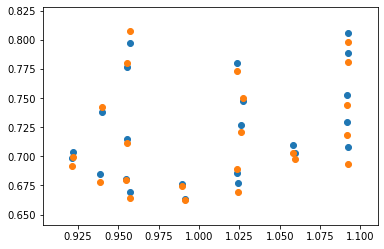

In [13]:
a = last_iv_2021.loc[_id,['mark_iv']]/100
b = last_iv_2021.loc[_id,['self_iv']]
c = last_iv_2021.loc[_id,['moneyness']]

plt.scatter(c,a)
plt.scatter(c,b)

In [14]:
def loss_fn(row, params, returnPrice=False):
    sigma, _lambda, eta1, eta2, q1 = params
    
    if returnPrice==False:
        if (sigma < 0) or (_lambda < 0) or (eta1 < 0) or (eta2 < 0) or (q1 > 1) or (q1<0):
            return 50000

#     S = row.index_price
    S = row.underlying_price
    K = row.strike
    t = 0 
    T = row.tau
    S_d = S/100
    S_u = S*100
    r = row.interest_rate/100
    d = 0
    si = row.is_call # 1 for call; -1 for put
    phi_bar_u = 0
    phi_bar_d = 0
    q2 = 1 - q1

    DEJD_price = BarrierOptionPricer(S,
                        sigma,
                        r,
                        d,
                        _lambda,
                        q1,
                        q2, eta1, eta2, 
                        T,
                        t,
                        K,
                        S_u,
                        S_d,
                        si,
                        phi_bar_u,
                        phi_bar_d,
                        N=8).price()
    
    if returnPrice:
        return DEJD_price
    else:
        if pd.isna(DEJD_price):
            return 50000
        market_price = row.instrument_price
        return np.abs((DEJD_price - market_price)/market_price)


@ray.remote(num_returns=1)
def loss_fn_parallel(row, params, returnPrice):
    return loss_fn(row, params, returnPrice)
    
params = [0.8, 0.6, 0.1, 0.1, 0.3]
error = ray.get([loss_fn_parallel.remote(row = last_iv_2021.iloc[i,:], params = params, returnPrice=False) for i  in range(len(last_iv_2021))])
print(np.sum(error))

4.791068044610225


In [15]:
def calibrationDEJD_loss(params):
#     error = ray.get([loss_fn_parallel.remote(row = last_iv_2021.iloc[i,:], 
#                                              params = params,
#                                              returnPrice=False) \
#                      for i in range(len(last_iv_2021))])
    sigma, _lambda, eta1, eta2, q1 = params
    
    if (sigma <= 0) or (_lambda <= 0) or (eta1 <= 0) or (eta2 <= 0) or (q1 >= 1) or (q1<=0):
        return 50000
    
    _df = last_iv_2021.copy()
    
#     _id = _df.is_call == 1
#     
#     _df = _df.loc[_id, :]

    
    error = ray.get([loss_fn_parallel.remote(row = _df .iloc[i,:], 
                                             params = params,
                                             returnPrice=False) \
                     for i in range(len(_df))])
    
    _mean = np.mean(error)
    print(params, _mean)
    return _mean*1000

In [16]:
last_iv_2021.loc[:, 'calibratedPrice'] = 0

In [18]:
x0      = [0.58430934, 0.98547438, 0.44295077, 0.43424554, 0.42512193] # sigma, _lambda, eta1, eta2, q1, from calibration

params = fmin(calibrationDEJD_loss, x0,
              xtol=.0000001, ftol=.0000001,
              maxfun=20000, maxiter=20000)

print(params)

[0.58430934 0.98547438 0.44295077 0.43424554 0.42512193] 0.013466024393652878
[0.61352481 0.98547438 0.44295077 0.43424554 0.42512193] 0.05421368881824395
[0.58430934 1.0347481  0.44295077 0.43424554 0.42512193] 0.01875895239667936
[0.58430934 0.98547438 0.46509831 0.43424554 0.42512193] 0.022396984047054903
[0.58430934 0.98547438 0.44295077 0.45595782 0.42512193] 0.01449776243888411
[0.58430934 0.98547438 0.44295077 0.43424554 0.44637803] 0.015526427140398041
[0.55509387 1.00518387 0.45180979 0.44293045 0.43362437] 0.044438006615518784
[0.56970161 1.0002565  0.44959503 0.44075922 0.43149876] 0.02418295607099593
[0.59891707 0.99040175 0.44516552 0.43641677 0.42724754] 0.03169161490633134
[0.57700547 0.99779281 0.44848765 0.43967361 0.43043595] 0.016635181232052855
[0.58138779 1.01011124 0.42301799 0.44510168 0.43574998] 0.01785572555269764
[0.58021917 0.95098278 0.43719241 0.44944413 0.4400012 ] 0.021998987068876596
[0.5832868  1.01380677 0.44151118 0.43804519 0.42884175] 0.01541111355

[0.58430988 0.9854582  0.44263327 0.43479127 0.42572141] 0.013467511147820207
[0.58431865 0.98527688 0.44325118 0.43382665 0.42461829] 0.013468757805775729
[0.584305   0.98555391 0.44256436 0.43484191 0.42584202] 0.013467647976097095
[0.58429416 0.98558482 0.4424105  0.43516446 0.42608028] 0.013468539577501154
[0.58430043 0.98553859 0.44255821 0.43490536 0.42583249] 0.013467551874748948
[0.58431001 0.98535652 0.44287092 0.4345057  0.42531926] 0.013467799090020702
[0.58430441 0.98554109 0.44262711 0.43474194 0.42571363] 0.013467089842574595
[0.58430732 0.98540009 0.44287751 0.43444449 0.42527097] 0.01346682169750668
[0.58431465 0.98536    0.44301138 0.43419669 0.4250559 ] 0.01346696568307354
[0.58430711 0.98540112 0.44308756 0.43407294 0.42490077] 0.013468548017574302
[0.58430919 0.98544393 0.44274684 0.43461169 0.42551625] 0.01346679026057365
[0.58431448 0.98527937 0.44314161 0.43407018 0.4248296 ] 0.013467447875868833
[0.58430693 0.98547566 0.44275574 0.434574   0.42549262] 0.01346658

[0.58430737 0.98557171 0.44295516 0.4341764  0.42507422] 0.013465859167181045
[0.5843074  0.985577   0.44295551 0.43417121 0.42507158] 0.013465856072297474
[0.58430727 0.98558575 0.44295673 0.43416341 0.42506587] 0.01346584911770069
[0.58430709 0.98558761 0.44295525 0.43416559 0.42506805] 0.013465848943918737
[0.58430675 0.9856017  0.44295571 0.43415631 0.42506175] 0.013465838852582391
[0.58430691 0.98559586 0.44295751 0.43415696 0.42506046] 0.013465839197301297
[0.5843071  0.98558516 0.44295576 0.43416656 0.4250684 ] 0.013465834762428094
[0.58430702 0.9855868  0.44295583 0.43416571 0.425068  ] 0.013465827344359095
[0.58430686 0.98560138 0.44295648 0.43415413 0.42506091] 0.013465840967184551
[0.58430629 0.98562599 0.44295959 0.43413468 0.42504505] 0.013465816988657347
[0.58430562 0.98565768 0.44296273 0.43411005 0.42502671] 0.013465801044676267
[0.58430599 0.98563161 0.44295858 0.43413386 0.42504526] 0.01346580167856149
[0.58430605 0.98562809 0.44295967 0.43413503 0.42504396] 0.0134658

[0.58412605 0.99288994 0.44364551 0.42873036 0.42101798] 0.013461665376657229
[0.58412545 0.99280887 0.44367102 0.42875989 0.42101564] 0.013461555214037713
[0.58412318 0.99286138 0.44368339 0.42871646 0.42097774] 0.01346153793408629
[0.58412037 0.99279058 0.44373042 0.42872142 0.42094191] 0.013461366094121477
[0.58411536 0.99304171 0.44374066 0.42854603 0.42082141] 0.013461442231849788
[0.58412351 0.99260645 0.4437282  0.42884577 0.42102521] 0.013461329514660966
[0.58412456 0.99231487 0.44377178 0.42900036 0.42108957] 0.013463274911274388
[0.58412308 0.99250331 0.44375172 0.42889428 0.42103637] 0.01346199055106659
[0.5841225  0.99294832 0.44367478 0.42866627 0.42095308] 0.013461606645968868
[0.5841141  0.99292606 0.44378618 0.4285775  0.42080287] 0.013461254236205714
[0.58410675 0.99301294 0.44386334 0.42844712 0.42065429] 0.013462712329198904
[0.58411701 0.99272115 0.44378781 0.42871398 0.42088974] 0.013462003741032803
[0.58412113 0.99289153 0.44370304 0.4286782  0.42093724] 0.0134614

[0.58407706 0.99423588 0.44396102 0.42756461 0.41997696] 0.013460835823140362
[0.58407138 0.99443889 0.44398144 0.42741777 0.4198577 ] 0.013460741030771179
[0.58408408 0.99399278 0.44391306 0.42777641 0.42014926] 0.013460716753328472
[0.58408684 0.99390043 0.44388362 0.42787404 0.4202288 ] 0.013460560226792404
[0.58407769 0.99422138 0.44393679 0.42760979 0.4200139 ] 0.013460606659766285
[0.58407631 0.99426583 0.44393234 0.42759285 0.41999935] 0.013460475833384415
[0.58407236 0.99440618 0.44393104 0.42751617 0.41993648] 0.013460234192855266
[0.58408013 0.99413782 0.44389347 0.42772491 0.42010843] 0.013460301612648398
[0.58406801 0.99457207 0.44394579 0.42739719 0.41984067] 0.013460275395948141
[0.58408263 0.99405627 0.44385485 0.42783107 0.42019361] 0.013460286945873512
[0.5840783  0.99420773 0.44386671 0.42772757 0.4201093 ] 0.013460487245049352
[0.58406573 0.9946516  0.44391312 0.42740472 0.41984659] 0.013460958300969628
[0.58408156 0.99408822 0.443891   0.42775671 0.42013325] 0.01346

[0.5840932  0.99353569 0.44378033 0.42827126 0.420539  ] 0.013459917859678478
[0.58409174 0.99356327 0.44378431 0.42825432 0.42052292] 0.013459892486319494
[0.58409383 0.99349055 0.44377305 0.42831277 0.4205706 ] 0.013459926388980515
[0.58409199 0.99354256 0.44378108 0.42827347 0.42053736] 0.013459882916794308
[0.5840902  0.99357075 0.44378513 0.42825829 0.42052165] 0.013459845613715469
[0.58409088 0.99356758 0.44378573 0.42825493 0.4205209 ] 0.013459848682597118
[0.58408943 0.99359226 0.44378788 0.42824306 0.42050864] 0.013459841947314543
[0.58408677 0.99364024 0.44379423 0.42821534 0.42048164] 0.013459803388689524
[0.58408761 0.99360374 0.44378953 0.42824466 0.42050497] 0.013459795606979227
[0.58408453 0.993641   0.44379457 0.42823019 0.4204864 ] 0.013459733719803012
[0.58408381 0.99370259 0.44380454 0.42817246 0.42044281] 0.013459743356756383
[0.58408274 0.99368559 0.44380137 0.42819816 0.42045844] 0.013459696405455301
[0.58407824 0.99374675 0.44380989 0.42817008 0.42042619] 0.01345

[0.58407715 0.99377308 0.44382343 0.4281364  0.42039709] 0.013459428880368477
[0.58407724 0.99377118 0.44382349 0.42813708 0.42039776] 0.013459430089803647
[0.5840771  0.99377489 0.44382376 0.42813482 0.42039581] 0.013459428663284123
[0.58407703 0.99377806 0.44382461 0.42813158 0.42039319] 0.013459428419927965
[0.5840769  0.99377977 0.44382474 0.42813096 0.42039244] 0.013459432273726287
[0.58407717 0.99377371 0.44382372 0.42813531 0.42039631] 0.013459427992617881
[0.58407714 0.99377367 0.44382342 0.42813597 0.42039679] 0.013459431104306906
[0.58407708 0.99377589 0.44382417 0.42813357 0.42039479] 0.013459427296881415
[0.58407703 0.99377834 0.44382472 0.4281312  0.4203929 ] 0.013459429277740983
[0.58407712 0.99377439 0.44382375 0.4281351  0.42039604] 0.013459427793990822
[0.58407708 0.99377633 0.44382438 0.42813289 0.42039428] 0.01345942918075301
[0.58407709 0.99377525 0.44382392 0.42813434 0.42039543] 0.01345942759907958
[0.58407718 0.99377204 0.44382325 0.42813724 0.42039779] 0.0134594

In [19]:
calibratedPrice_arr = []
for i in range(len(last_iv_2021)):
    
    price = loss_fn(row = last_iv_2021.iloc[i,:],
                    params = params,
                    returnPrice=True)
#     last_iv_2021.iloc[i,:].loc['calibratedPrice'] = price
    calibratedPrice_arr.append(price)
last_iv_2021.calibratedPrice = calibratedPrice_arr

In [20]:
last_iv_2021.loc[:, 'DEJD_iv'] = 0.000
last_iv_2021.loc[:, 'DEJD_iv_error'] = 0.000
for i in range(len(last_iv_2021)):
    row = last_iv_2021.iloc[i,:]
    sigma0 = row.self_iv
    S = row.underlying_price           
    K = row.strike
    t = 0 
    T = row.tau
    S_d = S/5000
    S_u = S*5000
    r = row.interest_rate/100
#     r = 0
    d = 0
    si = row.is_call # 1 for call; -1 for put
    phi_bar_u = 0
    phi_bar_d = 0
    target_price = row.calibratedPrice
    DEJD_iv, error = getBS_iv(S, sigma0, r, d, T, t, K, 
                                                         S_u, S_d, si, phi_bar_u, phi_bar_d,
                                                         target_price, N=16)
    
    last_iv_2021.loc[:, 'DEJD_iv'].iloc[i, :] = DEJD_iv
    last_iv_2021.loc[:, 'DEJD_iv_error'].iloc[i, :] = error

#     print(S, K, tau, 'DEJD_iv: ', round(DEJD_iv, 2), 'market_iv:', round(row.self_iv,2), target_price, row.instrument_price)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 15
         Function evaluations: 30
Optimization terminated successfully.
         Current function value: 0.000022
         Iterations: 15
         Function evaluations: 30
Optimization terminated successfully.
         Current function value: 0.000015
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 0.000033
         Iterations: 14
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: 0.000062
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 0.000022
         Iterations: 14
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: 0.000001
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/francis/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Users/francis/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


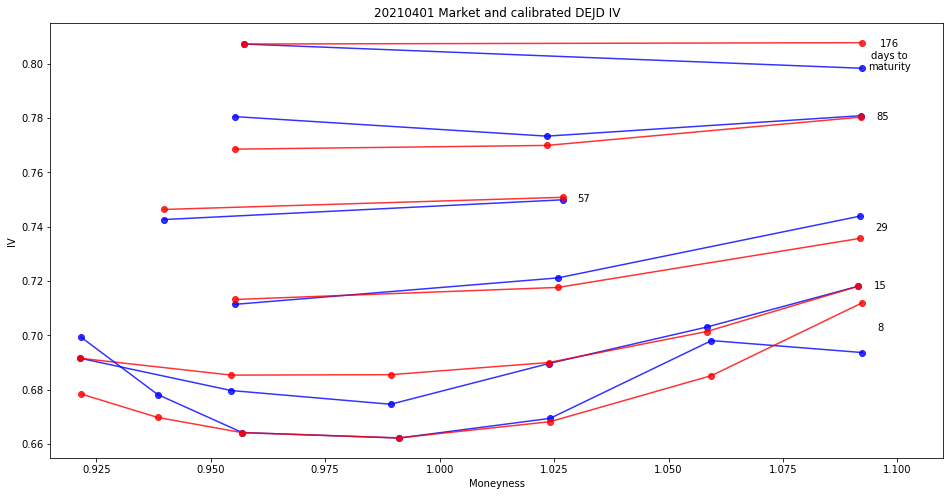

In [21]:
plt.figure(figsize=(16,8))
for i, tau in enumerate(sorted(list(set(last_iv_2021.tau)), reverse=True)):
#     plt.figure()
    _id = last_iv_2021.tau == tau
    _df = last_iv_2021.loc[_id,:].copy()
    _df = _df.sort_values('moneyness')
    D = _df.days_to_maturity.iloc[0]
    if i == 0:
        plt.plot(_df.moneyness, _df.self_iv, 'o-', color='blue', alpha=.8, label='Market')
        plt.plot(_df.moneyness, _df.DEJD_iv, 'o-', color='red', alpha=.8, label='Calibrated DEJD')
        plt.text(_df.moneyness.iloc[-1]*1.0055,
                 np.mean([_df.self_iv.iloc[-1], _df.DEJD_iv.iloc[-1]]),
                 str(D)+'\ndays to\nmaturity', 
                 ha='center', va='center')
    else: 
        plt.plot(_df.moneyness, _df.self_iv, 'o-', color='blue', alpha=.8)
        plt.plot(_df.moneyness, _df.DEJD_iv, 'o-', color='red', alpha=.8)
        plt.text(_df.moneyness.iloc[-1]*1.003,
                 np.mean([_df.self_iv.iloc[-1], _df.DEJD_iv.iloc[-1]]),
                 D, 
                 ha='left', va='center')
#     plt.scatter(_df.moneyness, _df.self_iv, color='blue', alpha=0.5)
#     plt.scatter(_df.moneyness, _df.DEJD_iv, color='red', alpha=0.5)
#     plt.ylim((0.5,0.8))

plt.title('20210401 Market and calibrated DEJD IV')
plt.ylabel('IV')
plt.xlabel('Moneyness')
# plt.legend()
plt.xlim((.915, 1.11))
plt.savefig('20210401_fittedIV.png', transparent=True)